## Учимся дообучать модели и знакомимся с аугментацией

In [1]:
import torch
import time
import os
import copy

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from skimage import io, img_as_float




print("PyTorch Version: ",torch.__version__)

PyTorch Version:  1.10.0+cu113


In [2]:
## Скачивание данных
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# !unzip hymenoptera_data.zip -d ./data/

In [3]:
data_dir = "./data/hymenoptera_data/"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

In [4]:
# Собираем все пути до картинок
def get_all_filepaths(directory):
    ants_directory = os.path.join(directory, "ants")
    bees_directory = os.path.join(directory, "bees")
    
    ants_images_filepaths = sorted([os.path.join(ants_directory, f) for f in os.listdir(ants_directory)])
    bees_images_filepaths = sorted([os.path.join(bees_directory, f) for f in os.listdir(bees_directory)])
    
    return [
        *ants_images_filepaths, *bees_images_filepaths
    ]

In [5]:
train_filepaths = get_all_filepaths(train_dir)
val_filepaths = get_all_filepaths(val_dir)

In [6]:
class DataGenerator(Dataset):
    def __init__(self,
                 images_filepaths,
                 transform=None # Тут будет аугментация
                ):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = img_as_float(io.imread(image_filepath)).astype(np.float32)[..., :3]
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "ants":
            label = 1
        else:
            label = 0
        if self.transform is not None:
             return self.transform(image=image)["image"].float(), label
        return torch.tensor(image.transpose([2, 0, 1])).float(), label

In [7]:
dataset = DataGenerator(train_filepaths)

In [8]:
def visualise(dataset, indexes):
    items = [dataset[index] for index in indexes]
    figure, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))
    for i, (image, _) in enumerate(items):
        ax.ravel()[i].imshow(image.numpy().transpose([2, 1, 0]))
        ax.ravel()[i].set_axis_off()
    plt.show()

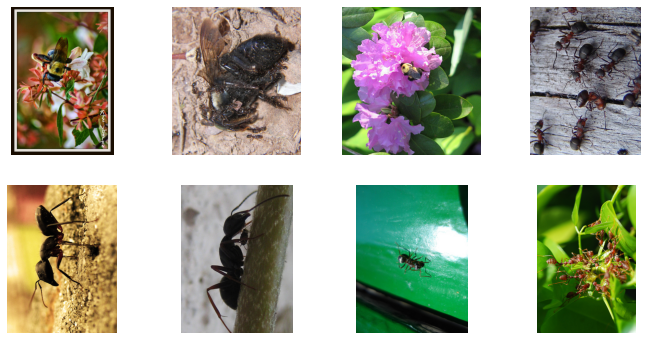

In [9]:
length = len(dataset)
indexes = np.random.choice(list(range(length)), size=8, replace=False)

visualise(dataset, indexes)

In [10]:
from torchvision import models

input_size = 224 # resnet учился на этом разрешении
model_ft = models.resnet18(pretrained=True)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# Заменим последний слой для 1000 классов на новый, для 2

num_classes = 2
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
# Учим только последний слой
for param in model_ft.parameters():
        param.requires_grad = False
        
model_ft.fc.weight.requires_grad = True
model_ft.fc.bias.requires_grad = True

In [13]:
# Вот это будем использовать для аугментации. Альтернатива из коробки: torchvision.transforms
import albumentations as A 
from albumentations.pytorch import ToTensorV2

In [14]:
example_transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5), # Случайные повороты/сдвиги/масштабирование
        A.SmallestMaxSize(max_size=input_size), # Приводим меньшую сторону к конкретному размеру
        A.RandomCrop(height=input_size, width=input_size), # Делаем срез нужного нам размера в случайном месте
        A.RGBShift(r_shift_limit=.7, g_shift_limit=.7, b_shift_limit=.7, p=0.5), # Смещаем цвет
        ToTensorV2(),# Приводим к тензору
    ]
)

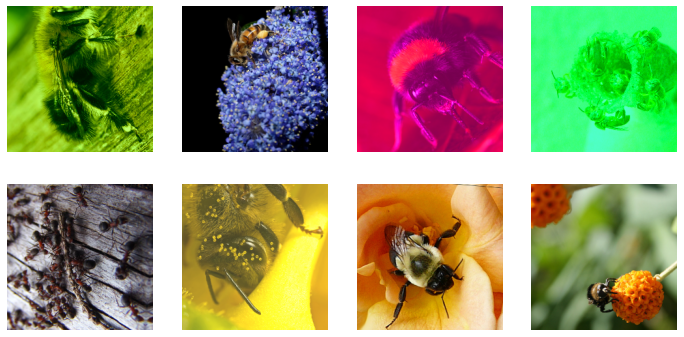

In [15]:
example_dataset = DataGenerator(train_filepaths, example_transform)

length = len(example_dataset)
indexes = np.random.choice(list(range(length)), size=8, replace=False)

visualise(example_dataset, indexes)

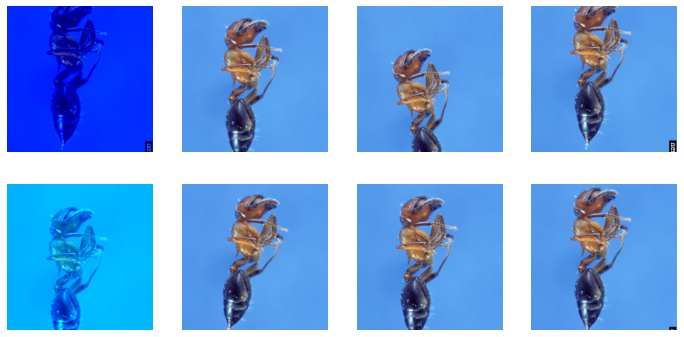

In [16]:
# Смотрим на один пример
visualise(example_dataset, [0]*8)

In [17]:
train_transform = A.Compose(
    [
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5), # Случайные повороты/сдвиги/масштабирование
        A.SmallestMaxSize(max_size=input_size), # Приводим меньшую сторону к конкретному размеру
        A.RandomCrop(height=input_size, width=input_size), # Делаем срез нужного нам размера в случайном месте
        A.RGBShift(r_shift_limit=0.7, g_shift_limit=0.7, b_shift_limit=0.7, p=0.5), # Смещаем цвет
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Нормализуем изображение яркость/ констраст
        ToTensorV2(),# Приводим к тензору
    ]
)

train_dataset = DataGenerator(train_filepaths, train_transform)



In [18]:
val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=input_size),# Приводим меньшую сторону к конкретному размеру
        A.CenterCrop(height=input_size, width=input_size),# Делаем срез нужного нам размера в центре
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Нормализуем изображение яркость/ констраст
        ToTensorV2(),
    ]
)

val_dataset = DataGenerator(val_filepaths, val_transform)


In [19]:

image_datasets = {'train':train_dataset,
                  'val': val_dataset}
# Создадим загурзчики
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x],
                                                   batch_size=16,
                                                   shuffle=True,
                                                   num_workers=8) for x in ['train', 'val']}

# Ищем ГПУ
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                

                optimizer.zero_grad()

                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [21]:
# Send the model to GPU
model_ft = model_ft.to(device).float()


optimizer_ft = optim.Adam([param for param in model_ft.parameters() if param.requires_grad], lr=0.001)

In [22]:

criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft,
                             dataloaders_dict, 
                             criterion,
                             optimizer_ft,
                             num_epochs=8)

Epoch 0/7
----------
train Loss: 0.7047 Acc: 0.5388
val Loss: 0.8000 Acc: 0.4575

Epoch 1/7
----------
train Loss: 0.6456 Acc: 0.6245
val Loss: 0.7700 Acc: 0.4575

Epoch 2/7
----------
train Loss: 0.6369 Acc: 0.6490
val Loss: 0.6836 Acc: 0.5033

Epoch 3/7
----------
train Loss: 0.6313 Acc: 0.6449
val Loss: 0.6185 Acc: 0.6209

Epoch 4/7
----------
train Loss: 0.6217 Acc: 0.6327
val Loss: 0.5888 Acc: 0.6601

Epoch 5/7
----------
train Loss: 0.6123 Acc: 0.6531
val Loss: 0.5330 Acc: 0.7778

Epoch 6/7
----------
train Loss: 0.6031 Acc: 0.6449
val Loss: 0.5323 Acc: 0.7647

Epoch 7/7
----------
train Loss: 0.5988 Acc: 0.6612
val Loss: 0.5186 Acc: 0.7712

Training complete in 0m 23s
Best val Acc: 0.777778
